In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import torch
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# ERRORS LEADING TO SUCCESS


In [ ]:
# Parameters
beta = beta_func(t)  # Transmission rate
gamma = gamma_func(t)
delta = delta_func(t)
alpha = alpha_func(t)
theta = theta_func(t)

# Total population, N
N = 1000

# Initial number of infected and recovered individuals, I0 and R0
E0, I0, R0 = 1, 1, 0

Q0 = 0
# Initially susceptible individuals, S0
S0 = N - I0 - R0 - E0 - Q0

# A grid of time points (in days)
t_span = [0, 365]  # Simulate for one year
t_eval = np.linspace(t_span[0], t_span[1], 365)

# Define the SEIQR model
def seiqr_model(t, y, N, beta, gamma, delta, alpha, theta):
    S, E, I, Q, R = y
    N = S + E + I + Q + R
    dSdt = -beta * S * (E+I)/N
    dEdt = beta * S * (E+I)/N - gamma*E - delta*E
    dIdt = gamma*E - alpha*I
    dQdt = alpha*I + delta*E - theta*Q
    dRdt = theta*Q
    return [dSdt, dEdt, dIdt, dQdt, dRdt]

NameError: name 'beta_func' is not defined

**NUMERICAL SOLUTIONS TO THE SEIRQ MODEL**


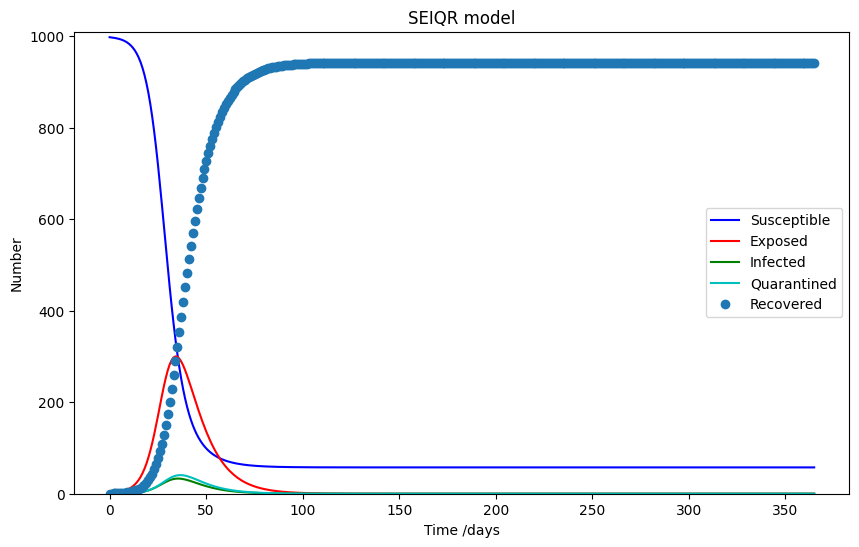

In [ ]:
# Initial conditions vector
y0 = [S0, E0, I0, Q0, R0]

# Integrate the SIR equations over the time grid, t
sol = solve_ivp(seiqr_model, t_span, y0, args=(N, beta, gamma, delta, alpha, theta), t_eval=t_eval, method='RK45')

# Extract the solution
S, E, I, Q, R = sol.y

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sol.t, S, 'b', label='Susceptible')
plt.plot(sol.t, E, 'r', label='Exposed')
plt.plot(sol.t, I, 'g', label='Infected')
plt.plot(sol.t, Q, 'c', label='Quarantined')
plt.plot(sol.t, R, 'o', label='Recovered')
plt.xlabel('Time /days')
plt.ylabel('Number')
plt.ylim(0, N+10)
plt.legend()
plt.title('SEIQR model')
plt.show()

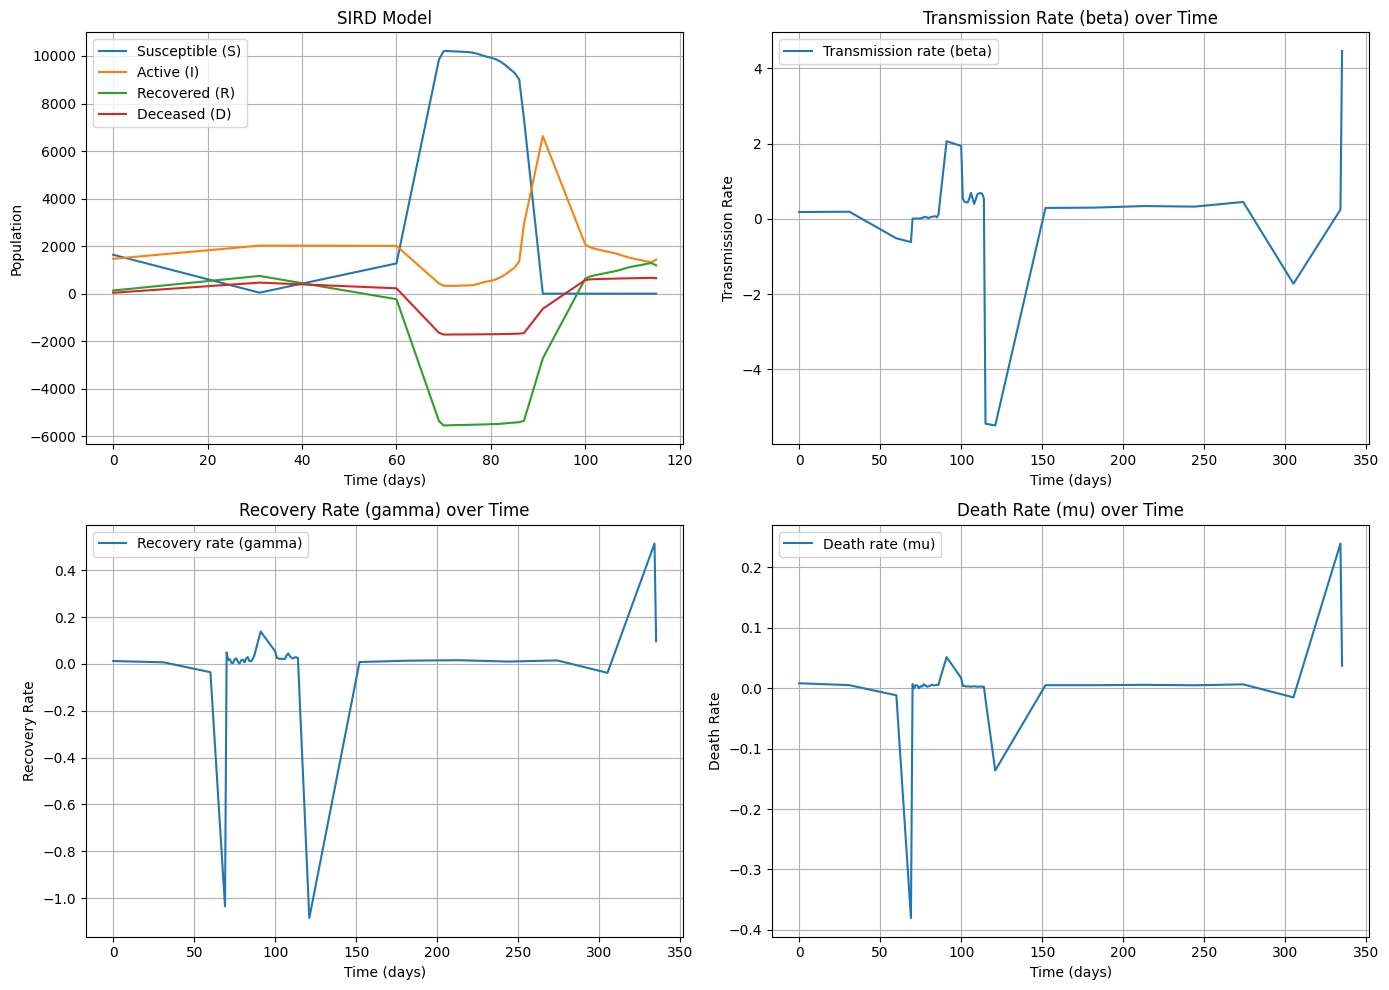

Solution:
Time (t): [  0  31  60  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  91 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115]
Susceptible (S): [ 1.63700000e+03  4.12227837e+01  1.27176858e+03  9.84893584e+03
  1.02079351e+04  1.02051145e+04  1.01957868e+04  1.01876785e+04
  1.01783772e+04  1.01668199e+04  1.01464869e+04  1.01009330e+04
  1.00373727e+04  9.97544597e+03  9.92936134e+03  9.86702693e+03
  9.76673791e+03  9.62941241e+03  9.45736830e+03  9.29413244e+03
  9.01456481e+03  7.37229652e+03  4.34093644e-02  6.20678992e-08
 -1.21287578e-08 -1.12831314e-07 -1.50312619e-07 -1.18438047e-07
 -9.18397485e-08 -6.73076486e-08 -4.72416614e-08 -3.65221007e-08
 -2.88761622e-08 -2.17853741e-08 -1.49305686e-08 -9.48171265e-09
 -1.52265887e-08 -1.41745068e-08  8.32591713e-09]
Active (I): [1466.         2022.29572063 2010.90522461  428.84347657  332.97333468
  328.96848483  329.04385735  331.62299639  338.93126726  345.1646354
  356.39978497 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Load data from Excel file
excel_file = 'send - Copy.xlsx'
data = pd.read_excel(excel_file)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by date
data = data.sort_values(by='Date')

# Calculate daily cases
data['Daily Active Cases'] = data['Active Cases']
data['Daily Recovered Cases'] = data['CuredDischarged']
data['Daily Death Cases'] = data['Death']

# Convert date to numerical values (elapsed time)
data['Elapsed Days'] = (data['Date'] - data['Date'].iloc[0]).dt.days

# Define time-dependent SIRD compartmental model
def sird_model(t, y, beta, gamma, mu):
    S, I, R, D = y
    N = S + I + R + D
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - (gamma(t) + mu(t)) * I
    dRdt = gamma(t) * I
    dDdt = mu(t) * I
    return [dSdt, dIdt, dRdt, dDdt]

# Train the model to estimate time-dependent parameters
def train_SIRD_model(daily_active_cases, daily_recovered_cases, daily_death_cases, initial_S, t):
    # Estimate parameters beta, gamma, mu
    beta = np.gradient(daily_active_cases) / initial_S
    gamma = np.gradient(daily_recovered_cases) / daily_active_cases
    mu = np.gradient(daily_death_cases) / daily_active_cases

    return beta, gamma, mu

# Example usage
initial_S = data['Confirmed Cases'].iloc[0]  # Initial susceptible population (e.g., total population)
t_span = [data['Elapsed Days'].iloc[0], data['Elapsed Days'].iloc[-1]]  # Time span in elapsed days
t_eval = data['Elapsed Days'].values  # Time points for evaluation

# Train the model to estimate parameters
beta, gamma, mu = train_SIRD_model(data['Daily Active Cases'], data['Daily Recovered Cases'], data['Daily Death Cases'], initial_S, t_eval)

# Solve SIRD model using estimated parameters
sol = solve_ivp(sird_model, t_span, [initial_S, data['Daily Active Cases'].iloc[0], data['Daily Recovered Cases'].iloc[0], data['Daily Death Cases'].iloc[0]], t_eval=t_eval, args=(lambda t: np.interp(t, t_eval, beta), lambda t: np.interp(t, t_eval, gamma), lambda t: np.interp(t, t_eval, mu)), method='RK45')

# Extract the solution
t = sol.t
S = sol.y[0]
I = sol.y[1]
R = sol.y[2]
D = sol.y[3]

# Plot the solution
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t, S, label='Susceptible (S)')
plt.plot(t, I, label='Active (I)')
plt.plot(t, R, label='Recovered (R)')
plt.plot(t, D, label='Deceased (D)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SIRD Model')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_eval, beta, label='Transmission rate (beta)')
plt.xlabel('Time (days)')
plt.ylabel('Transmission Rate')
plt.title('Transmission Rate (beta) over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_eval, gamma, label='Recovery rate (gamma)')
plt.xlabel('Time (days)')
plt.ylabel('Recovery Rate')
plt.title('Recovery Rate (gamma) over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(t_eval, mu, label='Death rate (mu)')
plt.xlabel('Time (days)')
plt.ylabel('Death Rate')
plt.title('Death Rate (mu) over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the solution
print("Solution:")
print("Time (t):", t)
print("Susceptible (S):", S)
print("Active (I):", I)
print("Recovered (R):", R)
print("Deceased (D):", D)
print("Transmission rate (beta):", beta)
print("Recovery rate (gamma):", gamma)
print("Death rate (mu):", mu)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K

# Load data from Excel file
excel_file = 'send - Copy.xlsx'
data = pd.read_excel(excel_file)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by date
data = data.sort_values(by='Date')

# Calculate daily cases
data['Daily Active Cases'] = data['Active Cases']
data['Daily Recovered Cases'] = data['CuredDischarged']
data['Daily Death Cases'] = data['Death']

# Convert date to numerical values (elapsed time)
data['Elapsed Days'] = (data['Date'] - data['Date'].iloc[0]).dt.days

# Define time-dependent SIRD compartmental model
def sird_model(t, y, beta, gamma, mu):
    S, I, R, D = y
    N = S + I + R + D
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - (gamma(t) + mu(t)) * I
    dRdt = gamma(t) * I
    dDdt = mu(t) * I
    return [dSdt, dIdt, dRdt, dDdt]

# Define the neural network model for parameter estimation
class ParameterEstimationModel(Model):
    def __init__(self):
        super(ParameterEstimationModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.beta_output = layers.Dense(1, activation='sigmoid')
        self.gamma_output = layers.Dense(1, activation='sigmoid')
        self.mu_output = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        beta = self.beta_output(x)
        gamma = self.gamma_output(x)
        mu = self.mu_output(x)
        return beta, gamma, mu

def custom_loss(observed, predicted, weights, theta_beta, theta_gamma, theta_mu, regularization_lambda):
    print("Shape of predicted:", K.int_shape(predicted))  # Debugging: Print shape of predicted tensor

    # Extract observed and predicted values for each compartment
    observed_S, observed_I, observed_R = observed[:, 0], observed[:, 1], observed[:, 2]
    predicted_S, predicted_I, predicted_R = predicted[:, 0], predicted[:, 0], predicted[:, 0]  # Accessing index 0 for each parameter

    # Compute weighted mean squared error for each compartment
    loss_S = K.mean(weights[0] * K.square(observed_S - predicted_S))
    loss_I = K.mean(weights[1] * K.square(observed_I - predicted_I))
    loss_R = K.mean(weights[2] * K.square(observed_R - predicted_R))

    # Compute regularization terms
    regularization_beta = K.mean(K.square(theta_beta))
    regularization_gamma = K.mean(K.square(theta_gamma))
    regularization_mu = K.mean(K.square(theta_mu))

    # Combine losses with regularization
    total_loss = loss_S + loss_I + loss_R + K.cast(regularization_lambda, dtype='float32') * (regularization_beta + regularization_gamma + regularization_mu)

    return total_loss


# Train the model to estimate time-dependent parameters
# Train the model to estimate time-dependent parameters
def train_SIRD_model(daily_active_cases, daily_recovered_cases, daily_death_cases, initial_S, t, weights, theta_beta, theta_gamma, theta_mu, regularization_lambda, max_epochs=100):
    # Define inputs and outputs
    X_train = np.vstack([daily_active_cases, daily_recovered_cases, daily_death_cases]).T
    y_train = np.vstack([beta_true, gamma_true, mu_true]).T  # True parameters for demonstration

    # Initialize the model
    model = ParameterEstimationModel()

    # Compile the model with custom loss function
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, weights, theta_beta, theta_gamma, theta_mu, regularization_lambda))

    # Training loop
    for epoch in range(max_epochs):
        # Forward Pass
        beta_estimated, gamma_estimated, mu_estimated = model.predict(X_train)

        # Inverse Pass: Update the weights and biases by minimizing the loss function
        model.fit(X_train, y_train, epochs=1, batch_size=32)

    # Get the final estimated parameters
    beta_final, gamma_final, mu_final = model.predict(X_train)

    return beta_final, gamma_final, mu_final


# Example usage
initial_S = data['Confirmed Cases'].iloc[0]  # Initial susceptible population (e.g., total population)
t_eval = data['Elapsed Days'].values  # Time points for evaluation

# True parameters for demonstration (Replace with real values)
beta_true = np.random.rand(len(t_eval))
gamma_true = np.random.rand(len(t_eval))
mu_true = np.random.rand(len(t_eval))

# Example usage with additional arguments
weights = [1, 1, 1, 1]  # Example weights
theta_beta = np.random.rand(64)  # Example theta_beta
theta_gamma = np.random.rand(64)  # Example theta_gamma
theta_mu = np.random.rand(64)  # Example theta_mu
regularization_lambda = 0.001  # Example regularization lambda

# Train the model to estimate parameters
beta, gamma, mu = train_SIRD_model(data['Daily Active Cases'], data['Daily Recovered Cases'], data['Daily Death Cases'], initial_S, t_eval, weights, theta_beta, theta_gamma, theta_mu, regularization_lambda)
# Solve SIRD model using estimated parameters
sol = solve_ivp(sird_model, [t_eval[0], t_eval[-1]], [initial_S, data['Daily Active Cases'].iloc[0], data['Daily Recovered Cases'].iloc[0], data['Daily Death Cases'].iloc[0]], t_eval=t_eval, args=(lambda t: np.interp(t, t_eval, beta.flatten()), lambda t: np.interp(t, t_eval, gamma.flatten()), lambda t: np.interp(t, t_eval, mu.flatten())), method='RK45')

# Extract the solution
t = sol.t
S = sol.y[0]
I = sol.y[1]
R = sol.y[2]
D = sol.y[3]

# Plot the solution
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t, S, label='Susceptible (S)')
plt.plot(t, I, label='Active (I)')
plt.plot(t, R, label='Recovered (R)')
plt.plot(t, D, label='Deceased (D)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SIRD Model')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_eval, beta, label='Transmission rate (beta)')
plt.xlabel('Time (days)')
plt.ylabel('Transmission Rate')
plt.title('Transmission Rate (beta) over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_eval, gamma, label='Recovery rate (gamma)')
plt.xlabel('Time (days)')
plt.ylabel('Recovery Rate')
plt.title('Recovery Rate (gamma) over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(t_eval, mu, label='Death rate (mu)')
plt.xlabel('Time (days)')
plt.ylabel('Death Rate')
plt.title('Death Rate (mu) over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the solution
print("Solution:")
print("Time (t):", t)
print("Susceptible (S):", S)
print("Active (I):", I)
print("Recovered (R):", R)
print("Deceased (D):", D)
print("Estimated Transmission rate (beta):", beta)
print("Estimated Recovery rate (gamma):", gamma)
print("Estimated Death rate (mu):", mu)


2/2 [==============================] - 0s 5ms/step
Shape of predicted: (None, 1)


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-14-ed4c2d70b398>", line 90, in None  *
        lambda y_true, y_pred: custom_loss(y_true, y_pred, weights, theta_beta, theta_gamma, theta_mu, regularization_lambda)
    File "<ipython-input-16-4e108997289c>", line 73, in custom_loss  *
        total_loss = loss_S + loss_I + loss_R + K.cast(regularization_lambda, dtype='float32') * (regularization_beta + regularization_gamma + regularization_mu)

    TypeError: Input 'y' of 'Mul' Op has type float64 that does not match type float32 of argument 'x'.


<ipython-input-10-18e20df1a184>:28: RuntimeWarning: overflow encountered in scalar multiply
  dSdt = -beta(t) * S * (I + epsilon * Q) / N
<ipython-input-10-18e20df1a184>:29: RuntimeWarning: overflow encountered in scalar multiply
  dEdt = beta(t) * S * (I + epsilon * Q) / N - sigma * E
<ipython-input-10-18e20df1a184>:27: RuntimeWarning: invalid value encountered in scalar add
  N = S + E + I + Q + R + D


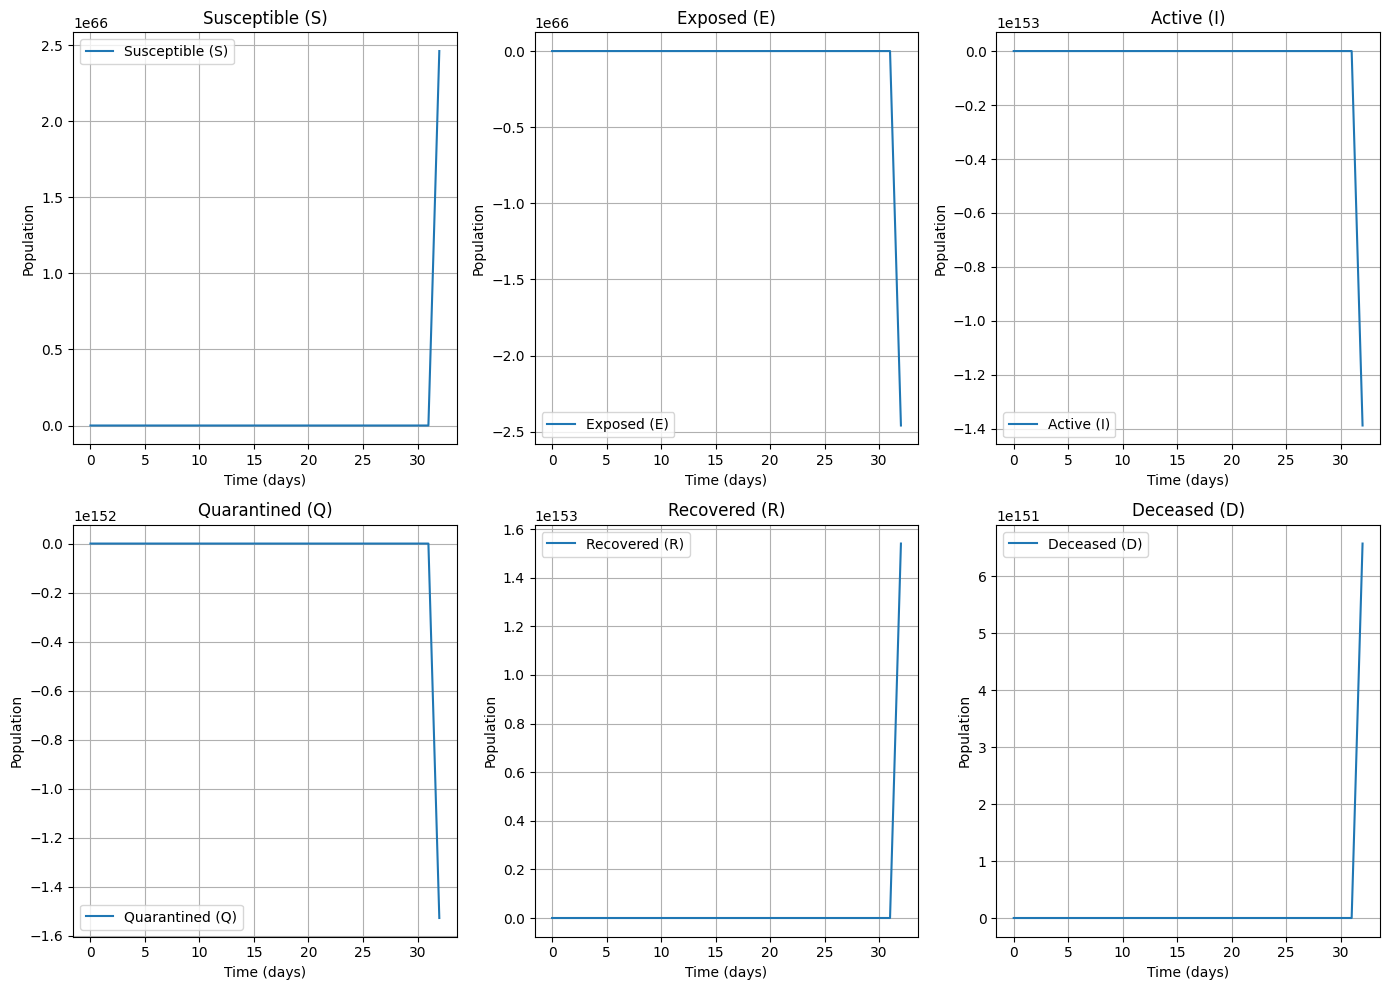

Solution:
Time (t): [ 0  1  2 31 32]
Susceptible (S): [ 1.63700000e+03  3.00593900e+02  2.12674844e+02 -7.87866625e-07
  2.46025708e+66]
Exposed (E): [ 0.00000000e+00  1.13896765e+03  1.00748733e+03  4.33559917e+01
 -2.45946692e+66]
Active (I): [ 1.46600000e+003  1.04151658e+002  2.11099385e+002 -3.15499555e+148
 -1.38745162e+153]
Quarantined (Q): [ 0.00000000e+000  7.46159449e+000  1.99016496e+001 -3.47437920e+147
 -1.52790486e+152]
Recovered (R): [1.33000000e+002 1.70456904e+003 1.82652057e+003 3.50243347e+148
 1.54024211e+153]
Deceased (D): [3.80000000e+001 2.24923565e+002 2.31256154e+002 1.60933693e+147
 6.57235277e+151]
Transmission rate (beta): [ 1.43805742e+01  2.80562004e+01 -7.09926695e+00 -2.05116066e+01
  2.92660354e+01 -7.35461210e+00 -2.12385461e+01  3.03631643e+01
 -8.54459377e+00 -3.09789249e+01  7.33048259e-03  8.24679291e-03
  7.63591936e-03  9.16310324e-03  8.55222969e-03  1.28283445e-02
  2.53512523e-02  4.82590104e-02  5.22296885e-02  3.57361026e-02
  2.04642639e-02

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Load data from Excel file
excel_file = 'send - Copy.xlsx'
data = pd.read_excel(excel_file)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by date
data = data.sort_values(by='Date')

# Calculate daily cases
data['Daily Active Cases'] = data['Active Cases']
data['Daily Recovered Cases'] = data['Cured/Discharged']
data['Daily Death Cases'] = data['Death']

# Convert date to numerical values (elapsed time)
data['Elapsed Days'] = (data['Date'] - data['Date'].iloc[0]).dt.days

# Define time-dependent SEIQR compartmental model
def seiqr_model(t, y, beta, sigma, gamma, epsilon, mu):
    S, E, I, Q, R, D = y
    N = S + E + I + Q + R + D
    dSdt = -beta(t) * S * (I + epsilon * Q) / N
    dEdt = beta(t) * S * (I + epsilon * Q) / N - sigma * E
    dIdt = sigma * E - gamma(t) * I
    dQdt = epsilon * sigma * E - gamma(t) * Q
    dRdt = gamma(t) * (I + Q)
    dDdt = mu(t) * I
    return [dSdt, dEdt, dIdt, dQdt, dRdt, dDdt]


# Train the model to estimate time-dependent parameters
def train_SEIQR_model(daily_active_cases, daily_recovered_cases, daily_death_cases, initial_S, t):
    # Estimate parameters beta, sigma, gamma, epsilon, mu
    beta = np.gradient(daily_active_cases) / initial_S
    sigma = 1/5  # Example latent period (5 days)
    gamma = np.gradient(daily_recovered_cases) / daily_active_cases
    epsilon = 0.1  # Example quarantine rate (10%)
    mu = np.gradient(daily_death_cases) / daily_active_cases

    return beta, sigma, gamma, epsilon, mu

# Example usage
initial_S = data['Confirmed Cases'].iloc[0]  # Initial susceptible population (e.g., total population)
t_span = [data['Elapsed Days'].iloc[0], data['Elapsed Days'].iloc[-1]]  # Time span in elapsed days
t_eval = data['Elapsed Days'].values  # Time points for evaluation

# Train the model to estimate parameters
beta, sigma, gamma, epsilon, mu = train_SEIQR_model(data['Daily Active Cases'], data['Daily Recovered Cases'], data['Daily Death Cases'], initial_S, t_eval)

# Solve SEIQR model using estimated parameters
sol = solve_ivp(seiqr_model, t_span, [initial_S, 0, data['Daily Active Cases'].iloc[0], 0, data['Daily Recovered Cases'].iloc[0], data['Daily Death Cases'].iloc[0]], t_eval=t_eval, args=(lambda t: np.interp(t, t_eval, beta), sigma, lambda t: np.interp(t, t_eval, gamma), epsilon, lambda t: np.interp(t, t_eval, mu)), method='RK45')

# Extract the solution
t = sol.t
S = sol.y[0]
E = sol.y[1]
I = sol.y[2]
Q = sol.y[3]
R = sol.y[4]
D = sol.y[5]

# Plot the solution
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.plot(t, S, label='Susceptible (S)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Susceptible (S)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(t, E, label='Exposed (E)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Exposed (E)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(t, I, label='Active (I)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Active (I)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(t, Q, label='Quarantined (Q)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Quarantined (Q)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(t, R, label='Recovered (R)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Recovered (R)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(t, D, label='Deceased (D)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Deceased (D)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the solution
print("Solution:")
print("Time (t):", t)
print("Susceptible (S):", S)
print("Exposed (E):", E)
print("Active (I):", I)
print("Quarantined (Q):", Q)
print("Recovered (R):", R)
print("Deceased (D):", D)
print("Transmission rate (beta):", beta)
print("Latent period (sigma):", sigma)
print("Recovery rate (gamma):", gamma)
print("Quarantine rate (epsilon):", epsilon)
print("Death rate (mu):", mu)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf

# Load data from Excel file
excel_file = 'send - Copy.xlsx'
data = pd.read_excel(excel_file)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by date
data = data.sort_values(by='Date')

# Calculate daily cases
data['Daily Active Cases'] = data['Active Cases']
data['Daily Recovered Cases'] = data['CuredDischarged']
data['Daily Death Cases'] = data['Death']

# Convert date to numerical values (elapsed time)
data['Elapsed Days'] = (data['Date'] - data['Date'].iloc[0]).dt.days

# Define SIRD compartmental model using DNNs
class SIRD_DNN(tf.keras.Model):
    def __init__(self):
        super(SIRD_DNN, self).__init__()
        self.dense_beta = tf.keras.layers.Dense(64, activation='relu')
        self.dense_gamma = tf.keras.layers.Dense(64, activation='relu')
        self.dense_mu = tf.keras.layers.Dense(64, activation='relu')
        self.dense_output_beta = tf.keras.layers.Dense(1)
        self.dense_output_gamma = tf.keras.layers.Dense(1)
        self.dense_output_mu = tf.keras.layers.Dense(1)

    def call(self, inputs):
        beta = self.dense_output_beta(self.dense_beta(inputs))
        gamma = self.dense_output_gamma(self.dense_gamma(inputs))
        mu = self.dense_output_mu(self.dense_mu(inputs))
        return beta, gamma, mu

# Initialize the SIRD DNN model
sird_model_dnn = SIRD_DNN()

# Define wrapper functions for tensors
def beta_wrapper(t):
    return tf.squeeze(sird_model_dnn(tf.constant([[t]], dtype=tf.float32))[0])

def gamma_wrapper(t):
    return tf.squeeze(sird_model_dnn(tf.constant([[t]], dtype=tf.float32))[1])

def mu_wrapper(t):
    return tf.squeeze(sird_model_dnn(tf.constant([[t]], dtype=tf.float32))[2])

# Define loss function
omega_S = 1.0  # Weight for susceptible compartment loss
omega_I = 1.0  # Weight for active compartment loss
omega_R = 1.0  # Weight for recovered compartment loss
omega_D = 1.0  # Weight for deceased compartment loss
omega_params = 1.0  # Weight for parameters loss

@tf.function
def loss_function(S, I, R, D, beta, gamma, mu):
    loss = (omega_S * tf.reduce_mean(tf.square(S)) +
            omega_I * tf.reduce_mean(tf.square(I)) +
            omega_R * tf.reduce_mean(tf.square(R)) +
            omega_D * tf.reduce_mean(tf.square(D)) +
            omega_params * (tf.reduce_mean(tf.square(beta)) +
                            tf.reduce_mean(tf.square(gamma)) +
                            tf.reduce_mean(tf.square(mu))))
    return loss

# Example usage
initial_S = data['Confirmed Cases'].iloc[0]  # Initial susceptible population (e.g., total population)
t_span = [data['Elapsed Days'].iloc[0], data['Elapsed Days'].iloc[-1]]  # Time span in elapsed days
t_eval = data['Elapsed Days'].values  # Time points for evaluation

# Convert data to numpy arrays
X = data[['Elapsed Days']].values
Y = data[['Daily Active Cases', 'Daily Recovered Cases', 'Daily Death Cases']].values

# Normalize the data
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
Y_mean, Y_std = Y.mean(axis=0), Y.std(axis=0)
X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std

# Define optimizer and epochs
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
max_epochs = 100

# Training loop
for epoch in range(max_epochs):
    with tf.GradientTape() as tape:
        beta_pred, gamma_pred, mu_pred = sird_model_dnn(X)
        S_pred, I_pred, R_pred, D_pred = solve_ivp(sird_model, t_span,
                                                   [initial_S, Y[0, 0], Y[0, 1], Y[0, 2]],
                                                   t_eval=t_eval,
                                                   args=(beta_wrapper, gamma_wrapper, mu_wrapper),
                                                   method='RK45').y

        # Calculate loss
        loss = loss_function(S_pred, I_pred, R_pred, D_pred, beta_pred, gamma_pred, mu_pred)

    # Calculate gradients
    gradients = tape.gradient(loss, sird_model_dnn.trainable_variables)

    # Update weights and bias
    optimizer.apply_gradients(zip(gradients, sird_model_dnn.trainable_variables))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# Get the final estimated parameters
final_beta, final_gamma, final_mu = sird_model_dnn(X)

# Denormalize parameters
final_beta = final_beta * Y_std[0]
final_gamma = final_gamma * Y_std[1]
final_mu = final_mu * Y_std[2]

# Plot the estimated parameters
plt.plot(t_eval, final_beta, label='Estimated Beta')
plt.plot(t_eval, final_gamma, label='Estimated Gamma')
plt.plot(t_eval, final_mu, label='Estimated Mu')
plt.xlabel('Time (days)')
plt.ylabel('Estimated Parameter Value')
plt.title('Estimated Parameters over Time')
plt.legend()
plt.grid(True)
plt.show()

# Save the time-varying value of 𝛽, 𝛾, 𝜇
time_varying_values = pd.DataFrame({
    'Time (days)': t_eval,
    'Beta (Transmission Rate)': final_beta,
    'Gamma (Recovery Rate)': final_gamma,
    'Mu (Death Rate)': final_mu
})

time_varying_values.to_csv('time_varying_values.csv', index=False)

print("Time-varying values of Beta, Gamma, and Mu have been saved to 'time_varying_values.csv'.")


NameError: name 'sird_model' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Load data from Excel file
file_path = "send.xlsx"
df = pd.read_excel(file_path)
num_samples, num_features = df.shape
print("Number of samples:", num_samples)
print("Number of features:", num_features)

# Extract relevant columns
confirmed_cases = df['Confirmed Cases'].values
active_cases = df['Active Cases'].values
cured_discharged = df['Cured/Discharged'].values
death = df['Death'].values

# Convert data to PyTorch tensor
input_data = torch.tensor([confirmed_cases, active_cases, cured_discharged, death], dtype=torch.float32)
input_data = input_data.transpose(0, 1)

class SIRDModel(nn.Module):
    def __init__(self):
        super(SIRDModel, self).__init__()
        self.beta_nn = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.gamma_nn = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.mu_nn = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, input_data):
        beta = self.beta_nn(input_data)
        gamma = self.gamma_nn(input_data)
        mu = self.mu_nn(input_data)
        return beta, gamma, mu

# Define SIRD model equations
def SIRD_model(y, t, beta, gamma, mu):
    S = y[0]
    I = y[1]
    R = y[2]
    D = y[3]
    N = S + I + R + D

    # Prevent division by zero
    epsilon = 1e-8
    if N < epsilon:
        N = epsilon

    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

# Initialize the model
model = SIRDModel()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
max_epochs = 100
omega_S = 1.0  # Weight for susceptible compartment loss
omega_I = 1.0  # Weight for infected compartment loss
omega_R = 1.0  # Weight for recovered compartment loss
omega_D = 1.0  # Weight for deceased compartment loss
omega_params = 1.0  # Weight for parameters loss

for epoch in range(max_epochs):
    # Forward pass
    beta_pred, gamma_pred, mu_pred = model(input_data)

    # Compute loss
    loss_S = 0
    loss_I = 0
    loss_R = 0
    loss_D = 0
    loss_params = 0

    for i in range(num_samples):
        # Solve SIRD model using odeint for each time point
        initial_conditions = input_data[i].tolist()
        t_points = np.arange(len(active_cases))
        #sol = odeint(SIRD_model, initial_conditions, t_points, args=(beta_pred[i].item(), gamma_pred[i].item(), mu_pred[i].item()))
        sol = odeint(SIRD_model, initial_conditions, t_points, args=(beta_pred[i].item(), gamma_pred[i].item(), mu_pred[i].item()), atol=1e-8, rtol=1e-6)
        S_pred, I_pred, R_pred, D_pred = sol.T

        # Compute loss for each time point
        loss_S += torch.mean((torch.tensor(S_pred) - input_data[:, 0])**2)
        loss_I += torch.mean((torch.tensor(I_pred) - input_data[:, 1])**2)
        loss_R += torch.mean((torch.tensor(R_pred) - input_data[:, 2])**2)
        loss_D += torch.mean((torch.tensor(D_pred) - input_data[:, 3])**2)

        # Compute parameters loss for each sample
        loss_params += torch.mean((beta_pred[i] - beta_pred.mean())**2 + (gamma_pred[i] - gamma_pred.mean())**2 + (mu_pred[i] - mu_pred.mean())**2)
    total_loss = omega_S * loss_S + omega_I * loss_I + omega_R * loss_R + omega_D * loss_D + omega_params * loss_params

    # Backward pass
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{max_epochs}], Loss: {total_loss.item()}')

# Plotting
plt.figure(figsize=(10, 6))

# Plot S, I, R, D
plt.plot(active_cases, label='Active Cases')
plt.plot(I_pred, label='Predicted Infected')
plt.plot(cured_discharged, label='Cured/Discharged')
plt.plot(death, label='Death')

plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('SIRD Model Predictions vs. Actual Data')
plt.legend()

plt.show()


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load data from Excel file and rename columns
file_path = "send.xlsx"
df = pd.read_excel(file_path)
df.rename(columns={'Confirmed Cases': 'S', 'Active Cases': 'I', 'Cured/Discharged': 'R', 'Death': 'D'}, inplace=True)

# Extract relevant columns
S = df['S'].values
I = df['I'].values
R = df['R'].values
D = df['D'].values

# Normalize data to [0, 1]
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)


S = normalize_data(S)
I = normalize_data(I)
R = normalize_data(R)
D = normalize_data(D)

# Step 2: Define neural networks for 𝛽, 𝛾, and 𝜇
class ParameterModel(tf.keras.Model):
    def __init__(self):
        super(ParameterModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid')  # Using sigmoid activation for values between 0 and 1

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Step 3: Define the SIRD compartmental model using predicted parameters
def sird_model(S, I, R, D, beta, gamma, mu):
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I - mu * I
    dR_dt = gamma * I
    dD_dt = mu * I
    return dS_dt, dI_dt, dR_dt, dD_dt

# Step 4: Define the loss function
def loss_function(S_true, I_true, R_true, D_true, S_pred, I_pred, R_pred, D_pred, omega_S, omega_I, omega_R, omega_D, omega_params):
    # Avoid division by zero and log(0)
    epsilon = 1e-7
    S_pred = tf.clip_by_value(S_pred, epsilon, 1.0 - epsilon)
    I_pred = tf.clip_by_value(I_pred, epsilon, 1.0 - epsilon)
    R_pred = tf.clip_by_value(R_pred, epsilon, 1.0 - epsilon)
    D_pred = tf.clip_by_value(D_pred, epsilon, 1.0 - epsilon)

    loss_S = tf.reduce_mean(tf.square(S_true - S_pred)) * omega_S
    loss_I = tf.reduce_mean(tf.square(I_true - I_pred)) * omega_I
    loss_R = tf.reduce_mean(tf.square(R_true - R_pred)) * omega_R
    loss_D = tf.reduce_mean(tf.square(D_true - D_pred)) * omega_D
    regularization_loss = tf.reduce_sum(tf.square(omega_params))  # Regularization term for parameters
    total_loss = loss_S + loss_I + loss_R + loss_D + regularization_loss
    return total_loss

total_loss_values = []  # Store total loss values

# Step 5: Define the optimizer and training loop
def train_SIRD_model(max_epoch, S_data, I_data, R_data, D_data, parameter_model, omega_S, omega_I, omega_R, omega_D, omega_params):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduce learning rate for stability
    clip_value = 5.0  # Gradient clipping value

    for epoch in range(max_epoch):
        with tf.GradientTape() as tape:
            beta = parameter_model(S_data)
            gamma = parameter_model(I_data)
            mu = parameter_model(R_data)
            S_pred, I_pred, R_pred, D_pred = sird_model(S_data, I_data, R_data, D_data, beta, gamma, mu)
            loss = loss_function(S_data, I_data, R_data, D_data, S_pred, I_pred, R_pred, D_pred, omega_S, omega_I, omega_R, omega_D, omega_params)

        gradients = tape.gradient(loss, parameter_model.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, clip_value)  # Gradient clipping

        optimizer.apply_gradients(zip(gradients, parameter_model.trainable_variables))

        total_loss_values.append(loss.numpy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Step 6: Define initial parameters and run training loop
max_epoch = 1000
omega_S = 1.0
omega_I = 1.0
omega_R = 1.0
omega_D = 1.0
omega_params = 0.01

# Reshape input data
S = S.reshape(-1, 1)  # Assuming S, I, R, D are 1D arrays
I = I.reshape(-1, 1)
R = R.reshape(-1, 1)
D = D.reshape(-1, 1)

# Initialize parameter models
beta_model = ParameterModel()
gamma_model = ParameterModel()
mu_model = ParameterModel()

# Train parameter models
train_SIRD_model(max_epoch, S, I, R, D, beta_model, omega_S, omega_I, omega_R, omega_D, omega_params)
train_SIRD_model(max_epoch, S, I, R, D, gamma_model, omega_S, omega_I, omega_R, omega_D, omega_params)
train_SIRD_model(max_epoch, S, I, R, D, mu_model, omega_S, omega_I, omega_R, omega_D, omega_params)

# Plot total loss
plt.figure(figsize=(10, 6))
plt.plot(total_loss_values, label='Total Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Output time-varying values of beta, gamma, and mu
beta_values = beta_model(S).numpy()
gamma_values = gamma_model(I).numpy()
mu_values = mu_model(R).numpy()

# Save values to text files
np.savetxt('beta_values.txt', beta_values)
np.savetxt('gamma_values.txt', gamma_values)
np.savetxt('mu_values.txt', mu_values)


In [ ]:
from google.colab import files

# Save data to files
np.savetxt('beta_values.txt', beta_values)
np.savetxt('gamma_values.txt', gamma_values)
np.savetxt('mu_values.txt', mu_values)

# Download files to local system
files.download('beta_values.txt')
files.download('gamma_values.txt')
files.download('mu_values.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

# Plot time-varying values of beta, gamma, and mu
plt.figure(figsize=(10, 6))

# Plot beta values
plt.subplot(3, 1, 1)
plt.plot(beta_values, label='Beta')
plt.title('Time-varying values of Beta')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Plot gamma values
plt.subplot(3, 1, 2)
plt.plot(gamma_values, label='Gamma')
plt.title('Time-varying values of Gamma')
plt.xlabel('Time')
plt.ylabel('Gamma')
plt.legend()

# Plot mu values
plt.subplot(3, 1, 3)
plt.plot(mu_values, label='Mu')
plt.title('Time-varying values of Mu')
plt.xlabel('Time')
plt.ylabel('Mu')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Denormalize data
def denormalize_data(data, original_data):
    return data * (np.max(original_data) - np.min(original_data)) + np.min(original_data)

# Denormalize S, E, I, R, D values
E_denorm = denormalize_data(E, df['E'].values)
I_denorm = denormalize_data(I, df['I'].values)
R_denorm = denormalize_data(R, df['R'].values)
D_denorm = denormalize_data(D, df['D'].values)

# Plot original SIRD values
plt.figure(figsize=(10, 6))
plt.plot(E_denorm, label='E')
plt.plot(I_denorm, label='I')
plt.plot(R_denorm, label='R')
plt.plot(D_denorm, label='D')
plt.title('Original SEIRD Values')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load data from Excel file and rename columns
file_path = "send.xlsx"
df = pd.read_excel(file_path)
confirmed_cases = df['Confirmed Cases'].values
df.rename(columns={'Confirmed Cases': 'E', 'Active Cases': 'I', 'Cured/Discharged': 'R', 'Death': 'D'}, inplace=True)

# Extract relevant columns
E = df['E'].values
I = df['I'].values
R = df['R'].values
D = df['D'].values

# Normalize data to [0, 1]
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

E = normalize_data(E)
I = normalize_data(I)
R = normalize_data(R)
D = normalize_data(D)

# Step 2: Define neural networks for 𝛽, 𝛾, and 𝜇
class ParameterModel(tf.keras.Model):
    def __init__(self):
        super(ParameterModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid')  # Using sigmoid activation for values between 0 and 1

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Step 3: Define the SEIRD compartmental model using predicted parameters
def seird_model(E, I, R, D, beta, gamma, mu):
    dE_dt = -beta * E * I
    dI_dt = beta * E * I - gamma * I - mu * I
    dR_dt = gamma * I
    dD_dt = mu * I
    return dE_dt, dI_dt, dR_dt, dD_dt

# Step 4: Define the loss function
def loss_function(E_true, I_true, R_true, D_true, E_pred, I_pred, R_pred, D_pred, omega_E, omega_I, omega_R, omega_D, omega_params):
    # Avoid division by zero and log(0)
    epsilon = 1e-7
    E_pred = tf.clip_by_value(E_pred, epsilon, 1.0 - epsilon)
    I_pred = tf.clip_by_value(I_pred, epsilon, 1.0 - epsilon)
    R_pred = tf.clip_by_value(R_pred, epsilon, 1.0 - epsilon)
    D_pred = tf.clip_by_value(D_pred, epsilon, 1.0 - epsilon)

    loss_E = tf.reduce_mean(tf.square(E_true - E_pred)) * omega_E
    loss_I = tf.reduce_mean(tf.square(I_true - I_pred)) * omega_I
    loss_R = tf.reduce_mean(tf.square(R_true - R_pred)) * omega_R
    loss_D = tf.reduce_mean(tf.square(D_true - D_pred)) * omega_D
    regularization_loss = tf.reduce_sum(tf.square(omega_params))  # Regularization term for parameters
    total_loss = loss_E + loss_I + loss_R + loss_D + regularization_loss
    return total_loss

total_loss_values = []  # Store total loss values
log_loss_values = []  # Store log(loss) values

# Step 5: Define the optimizer and training loop
def train_SEIRD_model(max_epoch, E_data, I_data, R_data, D_data, parameter_model, omega_E, omega_I, omega_R, omega_D, omega_params):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduce learning rate for stability
    clip_value = 5.0  # Gradient clipping value

    for epoch in range(max_epoch):
        with tf.GradientTape() as tape:
            beta = parameter_model(E_data)
            gamma = parameter_model(I_data)
            mu = parameter_model(R_data)
            E_pred, I_pred, R_pred, D_pred = seird_model(E_data, I_data, R_data, D_data, beta, gamma, mu)
            loss = loss_function(E_data, I_data, R_data, D_data, E_pred, I_pred, R_pred, D_pred, omega_E, omega_I, omega_R, omega_D, omega_params)

        gradients = tape.gradient(loss, parameter_model.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, clip_value)  # Gradient clipping
        optimizer.apply_gradients(zip(gradients, parameter_model.trainable_variables))

        # Calculate log(loss)
        log_loss = tf.math.log(loss)
        total_loss_values.append(loss.numpy())
        log_loss_values.append(log_loss.numpy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Step 6: Define initial parameters and run training loop
max_epoch = 1000
omega_E = 1.0
omega_I = 1.0
omega_R = 1.0
omega_D = 1.0
omega_params = 0.01

# Reshape input data
E = E.reshape(-1, 1)  # Assuming E, I, R, D are 1D arrays
I = I.reshape(-1, 1)
R = R.reshape(-1, 1)
D = D.reshape(-1, 1)

# Initialize parameter models
beta_model = ParameterModel()
gamma_model = ParameterModel()
mu_model = ParameterModel()

# Train parameter models
train_SEIRD_model(max_epoch, E, I, R, D, beta_model, omega_E, omega_I, omega_R, omega_D, omega_params)
train_SEIRD_model(max_epoch, E, I, R, D, gamma_model, omega_E, omega_I, omega_R, omega_D, omega_params)
train_SEIRD_model(max_epoch, E, I, R, D, mu_model, omega_E, omega_I, omega_R, omega_D, omega_params)

# Initial susceptible population (S)
initial_S = 138.31e7  # Initial susceptible population in crores

# Extract confirmed cases (E) and calculate daily change (Delta E)
delta_E = confirmed_cases[1:] - confirmed_cases[:-1]

# Calculate the rate of conversion from S to E (alpha)
conversion_rate = delta_E / initial_S

# Calculate decreasing susceptible population (S)
S = initial_S - confirmed_cases


# Plot log(loss)
plt.figure(figsize=(10, 6))
plt.plot(log_loss_values, label='Log Loss')
plt.title('Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Step 7: Output time-varying values of beta, gamma, and mu
beta_values = beta_model(E).numpy()
gamma_values = gamma_model(I).numpy()
mu_values = mu_model(R).numpy()

# Save values to text files
np.savetxt('beta_values.txt', beta_values)
np.savetxt('gamma_values.txt', gamma_values)
np.savetxt('mu_values.txt', mu_values)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Clip alpha values to be non-negative
alpha_values = np.clip(conversion_rate, 0, None)

# Plot time-varying values of beta, gamma, mu, and alpha
plt.figure(figsize=(10, 12))

# Plot beta values
plt.subplot(4, 1, 1)
plt.plot(beta_values, label='Beta')
plt.title('Time-varying values of Beta')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Plot gamma values
plt.subplot(4, 1, 2)
plt.plot(gamma_values, label='Gamma')
plt.title('Time-varying values of Gamma')
plt.xlabel('Time')
plt.ylabel('Gamma')
plt.legend()

# Plot mu values
plt.subplot(4, 1, 3)
plt.plot(mu_values, label='Mu')
plt.title('Time-varying values of Mu')
plt.xlabel('Time')
plt.ylabel('Mu')
plt.legend()

# Plot alpha values
plt.subplot(4, 1, 4)
plt.plot(alpha_values, label='Alpha')
plt.title('Time-varying values of Alpha')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Denormalize data
def denormalize_data(data, original_data):
    return data * (np.max(original_data) - np.min(original_data)) + np.min(original_data)

# Denormalize S, E, I, R, D values
E_denorm = denormalize_data(E, df['E'].values)
I_denorm = denormalize_data(I, df['I'].values)
R_denorm = denormalize_data(R, df['R'].values)
D_denorm = denormalize_data(D, df['D'].values)

# Plot original SIRD values
plt.figure(figsize=(10, 6))
plt.plot(S, label='S')
plt.plot(E_denorm, label='E')
plt.plot(I_denorm, label='I')
plt.plot(R_denorm, label='R')
plt.plot(D_denorm, label='D')
plt.title('Original SEIRD Values')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

# Plot original SIRD values
plt.figure(figsize=(10, 6))
plt.plot(E_denorm, label='E')
plt.plot(I_denorm, label='I')
plt.plot(R_denorm, label='R')
plt.plot(D_denorm, label='D')
plt.title('Original SEIRD Values')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Load data from Excel file
file_path = "send.xlsx"
df = pd.read_excel(file_path)
num_samples, num_features = df.shape

# Extract relevant columns
active_cases = df['Active Cases'].values
cured_discharged = df['Cured/Discharged'].values
death = df['Death'].values

# Normalize data
max_values = np.max([active_cases, cured_discharged, death], axis=1)
observed_data_normalized = np.array([active_cases, cured_discharged, death]) / max_values[:, None]

# Convert data to PyTorch tensor
input_data = torch.tensor(observed_data_normalized, dtype=torch.float32)
input_data = input_data.transpose(0, 1)

class SIRDModel(nn.Module):
    def __init__(self):
        super(SIRDModel, self).__init__()
        self.beta_nn = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.gamma_nn = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.mu_nn = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, input_data):
        beta = self.beta_nn(input_data)
        gamma = self.gamma_nn(input_data)
        mu = self.mu_nn(input_data)
        return beta, gamma, mu

# Define SIRD model equations
def SIRD_model(y, t, beta, gamma, mu):
    S, I, R, D = y
    N = S + I + R + D
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

# Initialize the model
model = SIRDModel()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
max_epochs = 100
omega_S = 1.0  # Weight for susceptible compartment loss
omega_I = 1.0  # Weight for infected compartment loss
omega_R = 1.0  # Weight for recovered compartment loss
omega_D = 1.0  # Weight for deceased compartment loss
omega_params = 1.0  # Weight for parameters loss

for epoch in range(max_epochs):
    # Forward pass
    beta_pred, gamma_pred, mu_pred = model(input_data)

    # Compute loss
    loss_S = 0
    loss_I = 0
    loss_R = 0
    loss_D = 0
    loss_params = 0

    for i in range(num_samples):
        # Solve SIRD model using odeint for each time point
        initial_conditions = input_data[i].tolist() + [0]
        t_points = np.arange(len(active_cases))
        sol = odeint(SIRD_model, initial_conditions, t_points, args=(beta_pred[i].item(), gamma_pred[i].item(), mu_pred[i].item()))
        S_pred, I_pred, R_pred, D_pred = sol.T

        # Compute loss for each time point
        loss_S += torch.mean((torch.tensor(S_pred) - input_data[:, 0])**2)
        loss_I += torch.mean((torch.tensor(I_pred) - input_data[:, 1])**2)
        loss_R += torch.mean((torch.tensor(R_pred) - input_data[:, 2])**2)

        # Compute parameters loss for each sample
        loss_params += torch.mean((beta_pred[i] - beta_pred.mean())**2 + (gamma_pred[i] - gamma_pred.mean())**2 + (mu_pred[i] - mu_pred.mean())**2)

    total_loss = omega_S * loss_S + omega_I * loss_I + omega_R * loss_R + omega_D * loss_D + omega_params * loss_params

    # Backward pass
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{max_epochs}], Loss: {total_loss.item()}')

# Denormalize predicted values
S_pred *= max_values[0]
I_pred *= max_values[1]
R_pred *= max_values[1]
D_pred *= max_values[2]

# Plotting
plt.figure(figsize=(15, 10))

# Plot S, I, R, D
plt.subplot(3, 2, 1)
plt.plot(active_cases, label='Active Cases')
plt.plot(S_pred, label='Predicted Susceptible')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(cured_discharged, label='Cured/Discharged')
plt.plot(I_pred, label='Predicted Infected')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(death, label='Death')
plt.plot(R_pred, label='Predicted Recovered')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(D_pred, label='Predicted Deceased')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()

plt.show()


In [ ]:
# Plotting SIRD graph
plt.figure(figsize=(12, 8))

# Plotting S, I, R, D
plt.plot(active_cases, label='Active Cases', color='blue', linestyle='-')
plt.plot(S_pred, label='Predicted Susceptible', color='green', linestyle='-')
plt.plot(I_pred, label='Predicted Infected', color='red', linestyle='-')
plt.plot(R_pred, label='Predicted Recovered', color='purple', linestyle='-')
plt.plot(D_pred, label='Predicted Deceased', color='black', linestyle='-')

plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.title('SIRD Model Simulation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plotting phase plane portrait (I vs S)
plt.figure(figsize=(8, 6))

plt.plot(S_pred, I_pred, label='Phase Plane Portrait', color='blue', linestyle='-')

plt.xlabel('Susceptible (S)')
plt.ylabel('Infected (I)')
plt.title('Phase Plane Portrait (I vs S)')
plt.legend()
plt.grid(True)
plt.show()


# **WORKING MODEL OF EPI - DNNs**

# ACTIVE CASES


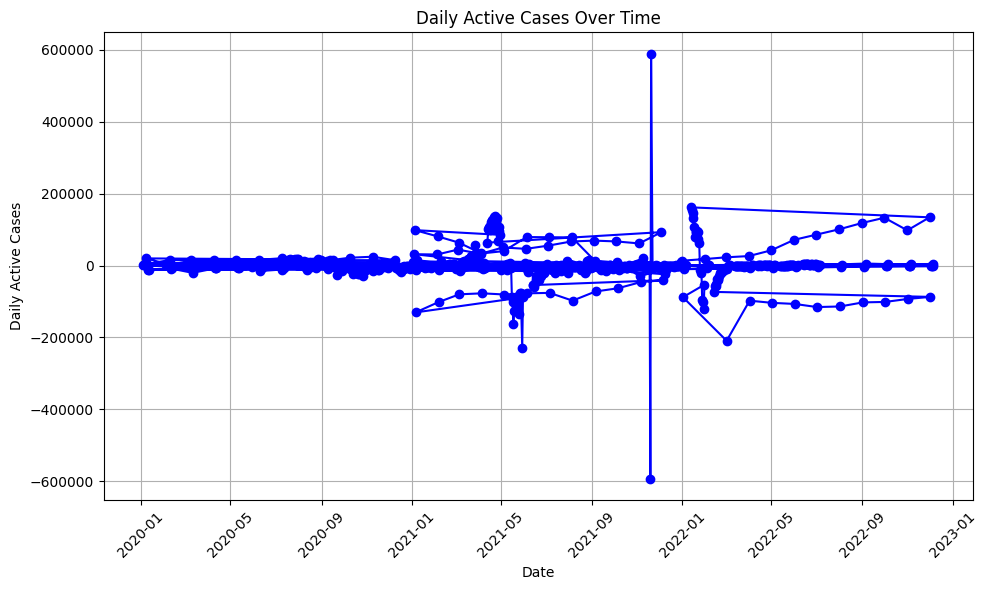

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_excel("send.xlsx")

# Convert date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Compute daily active cases
data['Daily Active Cases'] = data['Active Cases'].diff()

# Plot the daily active cases
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Daily Active Cases'], marker='o', color='b', linestyle='-')
plt.title('Daily Active Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Active Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **"THE MODEL"**

Epoch 0, Loss: 1.0232607126235962
Epoch 100, Loss: 1.0059510469436646
Epoch 200, Loss: 0.9918615818023682
Epoch 300, Loss: 0.9798567295074463
Epoch 400, Loss: 0.9700428247451782
Epoch 500, Loss: 0.9624887704849243
Epoch 600, Loss: 0.9568547606468201
Epoch 700, Loss: 0.9527021646499634
Epoch 800, Loss: 0.9496275186538696
Epoch 900, Loss: 0.9473258256912231
Epoch 0, Loss: 1.0267276763916016
Epoch 100, Loss: 1.0133970975875854
Epoch 200, Loss: 1.0000971555709839
Epoch 300, Loss: 0.9872211217880249
Epoch 400, Loss: 0.9759677648544312
Epoch 500, Loss: 0.9670279026031494
Epoch 600, Loss: 0.9602781534194946
Epoch 700, Loss: 0.9552884101867676
Epoch 800, Loss: 0.9516054391860962
Epoch 900, Loss: 0.9488633871078491
Epoch 0, Loss: 1.040471076965332
Epoch 100, Loss: 1.0303829908370972
Epoch 200, Loss: 1.0209453105926514
Epoch 300, Loss: 1.0111467838287354
Epoch 400, Loss: 1.0010586977005005
Epoch 500, Loss: 0.9907786846160889
Epoch 600, Loss: 0.9810712933540344
Epoch 700, Loss: 0.9725997447967529

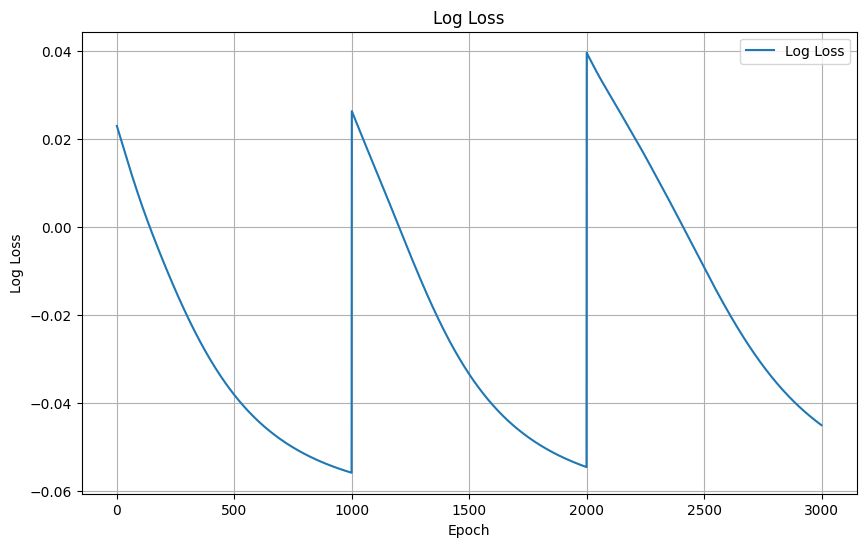

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

file_path = "send.xlsx"
df = pd.read_excel(file_path)
confirmed_cases = df['Confirmed Cases'].values
df.rename(columns={'Confirmed Cases': 'E', 'Active Cases': 'I', 'Cured/Discharged': 'R', 'Death': 'D'}, inplace=True)

E = df['E'].values
I = df['I'].values
R = df['R'].values
D = df['D'].values

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

E = normalize_data(E)
I = normalize_data(I)
R = normalize_data(R)
D = normalize_data(D)

class ParameterModel(tf.keras.Model):
    def __init__(self):
        super(ParameterModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

def seird_model(E, I, R, D, beta, gamma, mu):
    dE_dt = -beta * E * I
    dI_dt = beta * E * I - gamma * I - mu * I
    dR_dt = gamma * I
    dD_dt = mu * I
    return dE_dt, dI_dt, dR_dt, dD_dt

def loss_function(E_true, I_true, R_true, D_true, E_pred, I_pred, R_pred, D_pred, omega_E, omega_I, omega_R, omega_D, omega_params):

    epsilon = 1e-7 #To avoid division by 0 and log(0)
    E_pred = tf.clip_by_value(E_pred, epsilon, 1.0 - epsilon)
    I_pred = tf.clip_by_value(I_pred, epsilon, 1.0 - epsilon)
    R_pred = tf.clip_by_value(R_pred, epsilon, 1.0 - epsilon)
    D_pred = tf.clip_by_value(D_pred, epsilon, 1.0 - epsilon)

    loss_E = tf.reduce_mean(tf.square(E_true - E_pred)) * omega_E
    loss_I = tf.reduce_mean(tf.square(I_true - I_pred)) * omega_I
    loss_R = tf.reduce_mean(tf.square(R_true - R_pred)) * omega_R
    loss_D = tf.reduce_mean(tf.square(D_true - D_pred)) * omega_D
    regularization_loss = tf.reduce_sum(tf.square(omega_params))
    total_loss = loss_E + loss_I + loss_R + loss_D + regularization_loss
    return total_loss

total_loss_values = []
log_loss_values = []

def train_SEIRD_model(max_epoch, E_data, I_data, R_data, D_data, parameter_model, omega_E, omega_I, omega_R, omega_D, omega_params):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    clip_value = 5.0

    for epoch in range(max_epoch):
        with tf.GradientTape() as tape:
            beta = parameter_model(E_data)
            gamma = parameter_model(I_data)
            mu = parameter_model(R_data)
            E_pred, I_pred, R_pred, D_pred = seird_model(E_data, I_data, R_data, D_data, beta, gamma, mu)
            loss = loss_function(E_data, I_data, R_data, D_data, E_pred, I_pred, R_pred, D_pred, omega_E, omega_I, omega_R, omega_D, omega_params)

        gradients = tape.gradient(loss, parameter_model.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, clip_value)  # Gradient clipping
        optimizer.apply_gradients(zip(gradients, parameter_model.trainable_variables))

        # Calculate log(loss)
        log_loss = tf.math.log(loss)
        total_loss_values.append(loss.numpy())
        log_loss_values.append(log_loss.numpy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

max_epoch = 1000
omega_E = 1.0
omega_I = 1.0
omega_R = 1.0
omega_D = 1.0
omega_params = 0.01

E = E.reshape(-1, 1)
I = I.reshape(-1, 1)
R = R.reshape(-1, 1)
D = D.reshape(-1, 1)

beta_model = ParameterModel()
gamma_model = ParameterModel()
mu_model = ParameterModel()

train_SEIRD_model(max_epoch, E, I, R, D, beta_model, omega_E, omega_I, omega_R, omega_D, omega_params)
train_SEIRD_model(max_epoch, E, I, R, D, gamma_model, omega_E, omega_I, omega_R, omega_D, omega_params)
train_SEIRD_model(max_epoch, E, I, R, D, mu_model, omega_E, omega_I, omega_R, omega_D, omega_params)

initial_S = 138.31e7

delta_E = confirmed_cases[1:] - confirmed_cases[:-1]

conversion_rate = delta_E / initial_S

S = initial_S - confirmed_cases


plt.figure(figsize=(10, 6))
plt.plot(log_loss_values, label='Log Loss')
plt.title('Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()



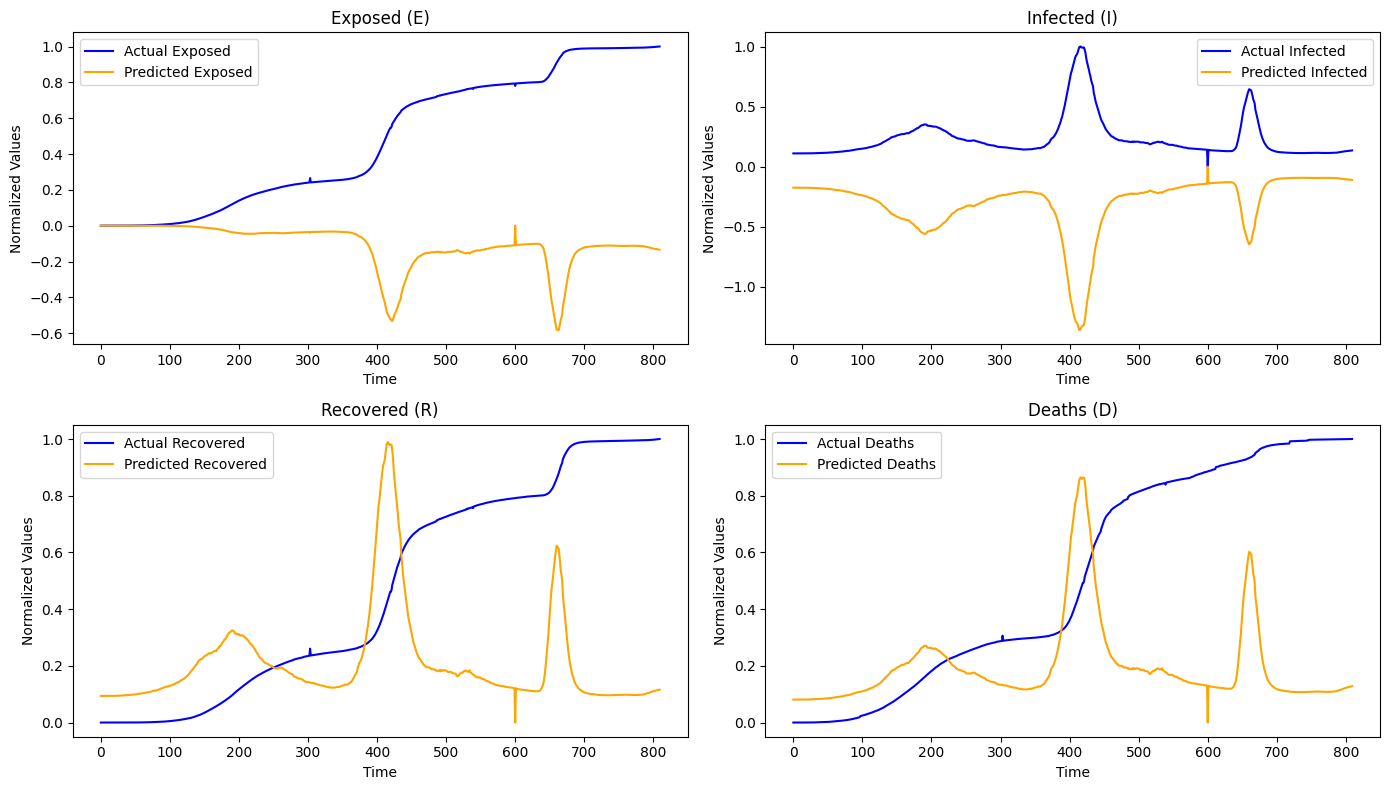

In [ ]:
def predict_seird(E, I, R, D, beta_model, gamma_model, mu_model):
    beta = beta_model(E)
    gamma = gamma_model(I)
    mu = mu_model(R)
    E_pred, I_pred, R_pred, D_pred = seird_model(E, I, R, D, beta, gamma, mu)
    return E_pred, I_pred, R_pred, D_pred

E_pred, I_pred, R_pred, D_pred = predict_seird(E, I, R, D, beta_model, gamma_model, mu_model)

# Convert predicted values from tensors to numpy arrays
E_pred = E_pred.numpy()
I_pred = I_pred.numpy()
R_pred = R_pred.numpy()
D_pred = D_pred.numpy()

# Plot the actual vs predicted values
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(E, label='Actual Exposed', color='blue')
plt.plot(E_pred, label='Predicted Exposed', color='orange')
plt.title('Exposed (E)')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(I, label='Actual Infected', color='blue')
plt.plot(I_pred, label='Predicted Infected', color='orange')
plt.title('Infected (I)')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(R, label='Actual Recovered', color='blue')
plt.plot(R_pred, label='Predicted Recovered', color='orange')
plt.title('Recovered (R)')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(D, label='Actual Deaths', color='blue')
plt.plot(D_pred, label='Predicted Deaths', color='orange')
plt.title('Deaths (D)')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()

plt.tight_layout()
plt.show()

# SAVING THE PARAMETER VALUES

In [ ]:

beta_values = beta_model(E).numpy()
gamma_values = gamma_model(I).numpy()
mu_values = mu_model(R).numpy()


np.savetxt('beta_values.txt', beta_values)
np.savetxt('gamma_values.txt', gamma_values)
np.savetxt('mu_values.txt', mu_values)

# PLOTTING ALL THE PARAMETERS

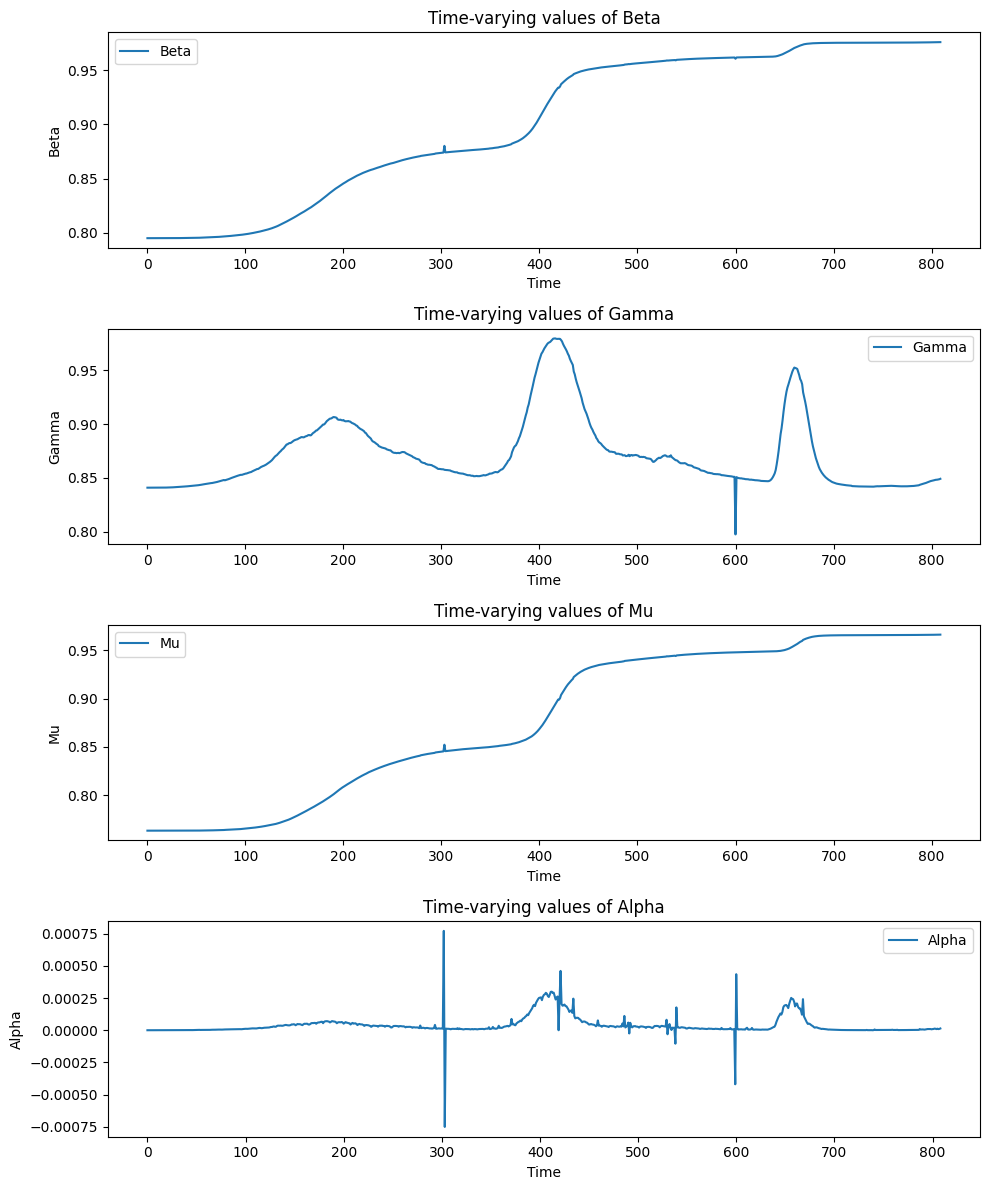

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Clip alpha values to be non-negative
alpha_values = np.clip(conversion_rate, 0, None)

plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(beta_values, label='Beta')
plt.title('Time-varying values of Beta')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()


plt.subplot(4, 1, 2)
plt.plot(gamma_values, label='Gamma')
plt.title('Time-varying values of Gamma')
plt.xlabel('Time')
plt.ylabel('Gamma')
plt.legend()


plt.subplot(4, 1, 3)
plt.plot(mu_values, label='Mu')
plt.title('Time-varying values of Mu')
plt.xlabel('Time')
plt.ylabel('Mu')
plt.legend()


plt.subplot(4, 1, 4)
plt.plot(conversion_rate, label='Alpha')
plt.title('Time-varying values of Alpha')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

plt.tight_layout()
plt.show()


# THE ORIGINAL SEIRD MODEL


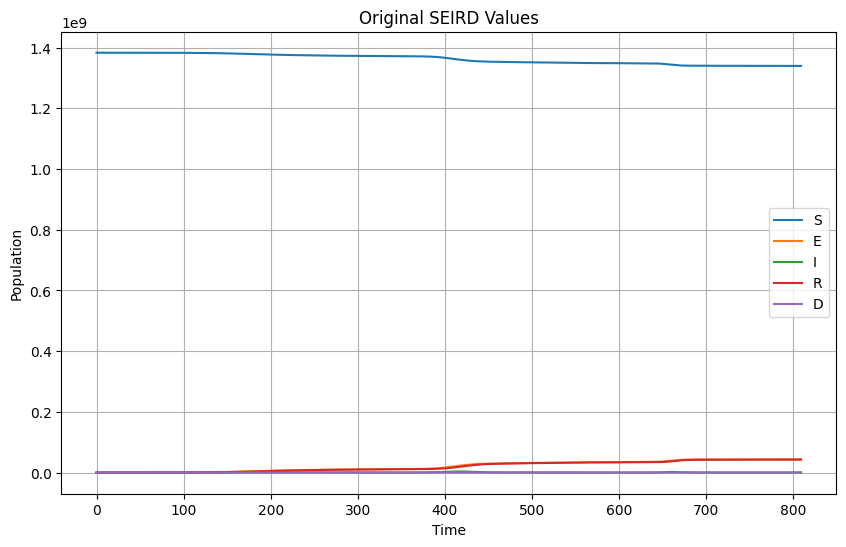

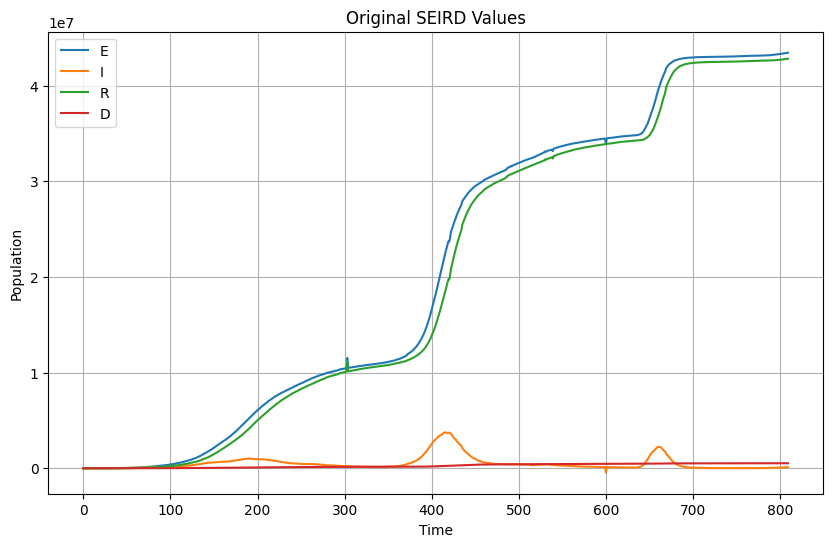

In [ ]:

def denormalize_data(data, original_data):
    return data * (np.max(original_data) - np.min(original_data)) + np.min(original_data)


E_denorm = denormalize_data(E, df['E'].values)
I_denorm = denormalize_data(I, df['I'].values)
R_denorm = denormalize_data(R, df['R'].values)
D_denorm = denormalize_data(D, df['D'].values)


plt.figure(figsize=(10, 6))
plt.plot(S, label='S')
plt.plot(E_denorm, label='E')
plt.plot(I_denorm, label='I')
plt.plot(R_denorm, label='R')
plt.plot(D_denorm, label='D')
plt.title('Original SEIRD Values')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(E_denorm, label='E')
plt.plot(I_denorm, label='I')
plt.plot(R_denorm, label='R')
plt.plot(D_denorm, label='D')
plt.title('Original SEIRD Values')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

Epoch 0, Loss: 1.855764521453355e+18
Epoch 100, Loss: 1.855764521453355e+18
Epoch 200, Loss: 1.855764521453355e+18
Epoch 300, Loss: 1.855764521453355e+18
Epoch 400, Loss: 1.855764521453355e+18
Epoch 500, Loss: 1.855764521453355e+18
Epoch 600, Loss: 1.855764521453355e+18
Epoch 700, Loss: 1.855764521453355e+18
Epoch 800, Loss: 1.855764521453355e+18
Epoch 900, Loss: 1.855764521453355e+18


ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 810, 1)

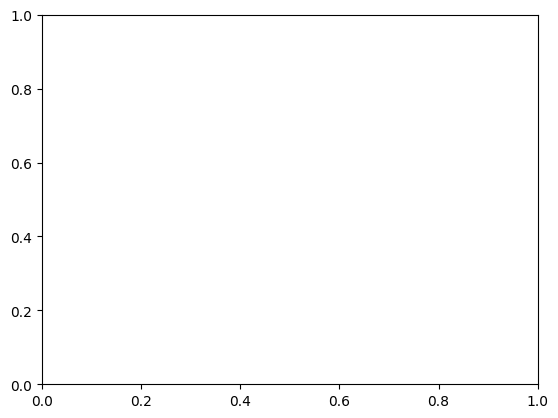

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
file_path = "send.xlsx"
df = pd.read_excel(file_path)
confirmed_cases = df['Confirmed Cases'].values
df.rename(columns={'Confirmed Cases': 'E', 'Active Cases': 'I', 'Cured/Discharged': 'R', 'Death': 'D'}, inplace=True)

E = df['E'].values
I = df['I'].values
R = df['R'].values
D = df['D'].values

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

E = normalize_data(E)
I = normalize_data(I)
R = normalize_data(R)
D = normalize_data(D)

# Step 2: Define the SIRD compartmental model and neural networks for parameters
class SIRDModel(tf.keras.Model):
    def __init__(self):
        super(SIRDModel, self).__init__()
        # Define neural networks for parameters
        self.beta_model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.gamma_model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.mu_model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs):
        # Forward pass through the neural networks
        beta = self.beta_model(inputs)
        gamma = self.gamma_model(inputs)
        mu = self.mu_model(inputs)
        return beta, gamma, mu

# Step 3: Define the fourth-order Runge-Kutta method for SIRD model
def runge_kutta_step(S, I, R, D, beta, gamma, mu, dt):
    # Implement the fourth-order Runge-Kutta method
    # Calculate derivatives at the midpoint of the interval
    dS1, dI1, dR1, dD1 = seird_model(S, I, R, D, beta, gamma, mu)
    dS2, dI2, dR2, dD2 = seird_model(S + 0.5 * dt * dS1, I + 0.5 * dt * dI1, R + 0.5 * dt * dR1, D + 0.5 * dt * dD1, beta, gamma, mu)
    dS3, dI3, dR3, dD3 = seird_model(S + 0.5 * dt * dS2, I + 0.5 * dt * dI2, R + 0.5 * dt * dR2, D + 0.5 * dt * dD2, beta, gamma, mu)
    dS4, dI4, dR4, dD4 = seird_model(S + dt * dS3, I + dt * dI3, R + dt * dR3, D + dt * dD3, beta, gamma, mu)
    # Update values using weighted average of derivatives
    S_new = S + (dt / 6.0) * (dS1 + 2 * dS2 + 2 * dS3 + dS4)
    I_new = I + (dt / 6.0) * (dI1 + 2 * dI2 + 2 * dI3 + dI4)
    R_new = R + (dt / 6.0) * (dR1 + 2 * dR2 + 2 * dR3 + dR4)
    D_new = D + (dt / 6.0) * (dD1 + 2 * dD2 + 2 * dD3 + dD4)
    return S_new, I_new, R_new, D_new

# Step 4: Define the SEIRD model
def seird_model(S, I, R, D, beta, gamma, mu):
    epsilon = 1e-7
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I - mu * I
    dR_dt = gamma * I
    dD_dt = mu * I
    return dS_dt, dI_dt, dR_dt, dD_dt

# Step 5: Define the loss function
def loss_function(S_true, I_true, R_true, D_true, S_pred, I_pred, R_pred, D_pred, beta_pred, gamma_pred, mu_pred, omega_S, omega_I, omega_R, omega_D, omega_params):
    epsilon = 1e-7
    S_pred = tf.clip_by_value(S_pred, epsilon, 1.0 - epsilon)
    I_pred = tf.clip_by_value(I_pred, epsilon, 1.0 - epsilon)
    R_pred = tf.clip_by_value(R_pred, epsilon, 1.0 - epsilon)
    D_pred = tf.clip_by_value(D_pred, epsilon, 1.0 - epsilon)

    loss_S = tf.reduce_mean(tf.square(S_true - S_pred)) * omega_S
    loss_I = tf.reduce_mean(tf.square(I_true - I_pred)) * omega_I
    loss_R = tf.reduce_mean(tf.square(R_true - R_pred)) * omega_R
    loss_D = tf.reduce_mean(tf.square(D_true - D_pred)) * omega_D
    loss_beta = tf.reduce_mean(tf.square(beta_pred)) * omega_params
    loss_gamma = tf.reduce_mean(tf.square(gamma_pred)) * omega_params
    loss_mu = tf.reduce_mean(tf.square(mu_pred)) * omega_params
    total_loss = loss_S + loss_I + loss_R + loss_D + loss_beta + loss_gamma + loss_mu
    return total_loss


# Step 6: Define the training loop
def train_SIRD_model(max_epoch, S_data, I_data, R_data, D_data, sird_model, omega_S, omega_I, omega_R, omega_D, omega_params):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    clip_value = 5.0
    dt = 1  # Time step for Runge-Kutta method

    beta_history = []
    gamma_history = []
    mu_history = []

    for epoch in range(max_epoch):
        with tf.GradientTape() as tape:
            beta_pred, gamma_pred, mu_pred = sird_model(S_data)
            S_pred, I_pred, R_pred, D_pred = runge_kutta_step(S_data, I_data, R_data, D_data, beta_pred, gamma_pred, mu_pred, dt)
            loss = loss_function(S_data, I_data, R_data, D_data, S_pred, I_pred, R_pred, D_pred, beta_pred, gamma_pred, mu_pred, omega_S, omega_I, omega_R, omega_D, omega_params)

        gradients = tape.gradient(loss, sird_model.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
        optimizer.apply_gradients(zip(gradients, sird_model.trainable_variables))

        if epoch == max_epoch - 1:
            beta_history.append(beta_pred.numpy())
            gamma_history.append(gamma_pred.numpy())
            mu_history.append(mu_pred.numpy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    return beta_history, gamma_history, mu_history

# Step 7: Prepare data and initialize the SIRD model
max_epoch = 1000
omega_S = 1.0
omega_I = 1.0
omega_R = 1.0
omega_D = 1.0
omega_params = 0.01

initial_S = 138.31e7
S = initial_S - confirmed_cases
S = S.reshape(-1, 1)
I = I.reshape(-1, 1)
R = R.reshape(-1, 1)
D = D.reshape(-1, 1)

sird_model = SIRDModel()

# Step 8: Train the SIRD model and save the time-varying values of 𝛽, 𝛾, 𝜇
beta_history, gamma_history, mu_history = train_SIRD_model(max_epoch, S, I, R, D, sird_model, omega_S, omega_I, omega_R, omega_D, omega_params)

# Step 9: Plot the time-varying values of 𝛽, 𝛾, 𝜇
plt.plot(beta_history, label='Beta')
plt.plot(gamma_history, label='Gamma')
plt.plot(mu_history, label='Mu')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time-varying values of Beta, Gamma, Mu')
plt.legend()
plt.show()


Importing Libraries and Data


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
file_path = "send.xlsx"
df = pd.read_excel(file_path)
confirmed_cases = df['Confirmed Cases'].values
df.rename(columns={'Confirmed Cases': 'E', 'Active Cases': 'I', 'Cured/Discharged': 'R', 'Death': 'D'}, inplace=True)

E = df['E'].values
I = df['I'].values
R = df['R'].values
D = df['D'].values

Normalizing the data

In [ ]:
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

E = normalize_data(E)
I = normalize_data(I)
R = normalize_data(R)
D = normalize_data(D)